In [247]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from numba import jit
import os
import random
import psycopg2
import json


In [248]:

@jit(nopython=True)
def simulate_numba(num_steps, k_e_square, W_e, L_e_plus, W_plus, L_plus_e, eta_batch, dt, epsilon, r_m, k_plus_square):
    phi_e = np.array([0.0, 0.0])
    phi_plus = np.array([0.0, 0.0])
    U = 0.01
    
    phi_e_history = np.zeros((num_steps, 2))
    phi_plus_history = np.zeros((num_steps, 2))
    U_history = np.zeros(num_steps)
    R_vals = np.zeros(num_steps)
    k_e_psi_e_vals = np.zeros(num_steps)
    k_e_b_e_vals = np.zeros(num_steps)
    k_e_psi_plus_vals = np.zeros(num_steps)
    k_e_b_plus_vals = np.zeros(num_steps)
    heat_flux_psi_e_b_e_vals = np.zeros(num_steps)
    heat_flux_psi_e_b_plus_vals = np.zeros(num_steps)
    b_e_psi_plus_vals = np.zeros(num_steps)
    b_e_b_plus_vals = np.zeros(num_steps)
    psi_plus_b_plus_vals = np.zeros(num_steps)

    switch_times = []

    for i in range(num_steps):
        eta = eta_batch[i]
        xi = np.array([2 * np.sqrt(2) * eta[0] / np.sqrt(k_e_square), 0.0])
        phi_e_dot = np.zeros(2)
        phi_plus_dot = np.zeros(2)

        phi_e_dot[0] = W_e[0, 0] * phi_e[0] + W_e[0, 1] * phi_e[1] + U * (
            L_e_plus[0, 0] * phi_plus[0] + L_e_plus[0, 1] * phi_plus[1]) + (np.sqrt(epsilon) * xi[0]) / np.sqrt(dt)
        phi_e_dot[1] = W_e[1, 0] * phi_e[0] + W_e[1, 1] * phi_e[1] + U * (
            L_e_plus[1, 0] * phi_plus[0] + L_e_plus[1, 1] * phi_plus[1]) + (np.sqrt(epsilon) * xi[1]) / np.sqrt(dt)

        phi_plus_dot[0] = W_plus[0, 0] * phi_plus[0] + W_plus[0, 1] * phi_plus[1] + U * (
            L_plus_e[0, 0] * phi_e[0] + L_plus_e[0, 1] * phi_e[1])
        phi_plus_dot[1] = W_plus[1, 0] * phi_plus[0] + W_plus[1, 1] * phi_plus[1] + U * (
            L_plus_e[1, 0] * phi_e[0] + L_plus_e[1, 1] * phi_e[1])

        phi_e[0] += phi_e_dot[0] * dt
        phi_e[1] += phi_e_dot[1] * dt
        phi_plus[0] += phi_plus_dot[0] * dt
        phi_plus[1] += phi_plus_dot[1] * dt

        R = 0.25 * k * (k_plus_square - k_e_square) * phi_e[0] * phi_plus[0]
        U_dot = R - r_m * U
        U += U_dot * dt

        phi_e_history[i, 0] = phi_e[0]
        phi_e_history[i, 1] = phi_e[1]
        phi_plus_history[i, 0] = phi_plus[0]
        phi_plus_history[i, 1] = phi_plus[1]

        psi_e = phi_e[0]
        b_e = phi_e[1]
        psi_plus = phi_plus[0]
        b_plus = phi_plus[1]

        U_history[i] = U
        R_vals[i] = R

        k_e_psi_e_vals[i] = psi_e*psi_e
        k_e_b_e_vals[i] = b_e*b_e
        k_e_psi_plus_vals[i] = psi_plus*psi_plus
        k_e_b_plus_vals[i] = b_plus*b_plus
        heat_flux_psi_e_b_e_vals[i] = psi_e*b_e
        heat_flux_psi_e_b_plus_vals[i] = psi_e*b_plus
        b_e_psi_plus_vals[i] = b_e*psi_plus
        b_e_b_plus_vals[i] = b_e*b_plus
        psi_plus_b_plus_vals[i] = psi_plus*b_plus
        


        if i > 0:
            if U_history[i - 1] > 0 and U_history[i] < 0:
                switch_times.append(i)
    return phi_e_history, phi_plus_history, U_history, R_vals, k_e_psi_e_vals, k_e_b_e_vals, k_e_psi_plus_vals, k_e_b_plus_vals, heat_flux_psi_e_b_e_vals, heat_flux_psi_e_b_plus_vals, b_e_psi_plus_vals, b_e_b_plus_vals, psi_plus_b_plus_vals, switch_times

class Simulation:
    def __init__(self, epsilon, N_0_squared, r_m, k, m, m_u, dt, total_time):
        self.epsilon = epsilon
        self.N_0_squared = N_0_squared
        self.r_m = r_m
        self.k = k
        self.m = m
        self.m_u = m_u
        self.dt = dt
        self.total_time = total_time
        self.num_steps = int(total_time / dt)
        self.k_e_square = k**2 + m**2
        self.k_plus_square = k**2 + (m + m_u)**2
        self.eta_batch = self.generate_eta_batch()
        self.W_e = np.array([[-1, (k / self.k_e_square)], [-k * N_0_squared, -1]])
        self.W_plus = np.array([[-1, -k / self.k_plus_square], [k * N_0_squared, -1]])
        self.L_e_plus = np.array([[(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), 0],
                                  [0, k / 2]])
        self.L_plus_e = np.array([[(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), 0],
                                  [0, -k / 2]])

        self.phi_e_history = np.zeros((self.num_steps, 2))
        self.phi_plus_history = np.zeros((self.num_steps, 2))
        self.U_history = np.zeros(self.num_steps)
        self.R_vals = np.zeros(self.num_steps)
        self.k_e_psi_e_vals = np.zeros(self.num_steps)
        self.k_e_b_e_vals = np.zeros(self.num_steps)
        self.k_e_psi_plus_vals = np.zeros(self.num_steps)
        self.k_e_b_plus_vals = np.zeros(self.num_steps)
        self.heat_flux_psi_e_b_e_vals = np.zeros(self.num_steps)
        self.heat_flux_psi_e_b_plus_vals = np.zeros(self.num_steps)
        self.b_e_psi_plus_vals = np.zeros(self.num_steps)
        self.b_e_b_plus_vals = np.zeros(self.num_steps)
        self.psi_plus_b_plus_vals = np.zeros(self.num_steps)

    def generate_eta_batch(self):
        return np.random.normal(0, 1, size=(self.num_steps, 1))

    def simulate(self):
        self.phi_e_history, self.phi_plus_history, self.U_history, self.R_vals, self.k_e_psi_e_vals, self.k_e_b_e_vals, self.k_e_psi_plus_vals, self.k_e_b_plus_vals, self.heat_flux_psi_e_b_e_vals, self.heat_flux_psi_e_b_plus_vals, self.b_e_psi_plus_vals, self.b_e_b_plus_vals, self.psi_plus_b_plus_vals, self.switch_times = simulate_numba(
            self.num_steps, self.k_e_square, self.W_e, self.L_e_plus, self.W_plus, self.L_plus_e, self.eta_batch, self.dt, self.epsilon, self.r_m, self.k_plus_square)
        
    
    def plot(self):
        time_array = np.arange(0, self.total_time, .001)
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))

       
        axs[0].plot(time_array, self.U_history)
        axs[0].set_title(f"U History")
        axs[0].grid()
        axs[1].plot(time_array, self.R_vals)
        axs[1].set_title(f"R Values")
        axs[1].grid()


        plt.show()


if __name__ == "__main__":
    # simulations = []
    # epsilon = 0.12394270273516043
    # N_0_squared = 318.8640217310387
    epsilon = 0.06
    N_0_squared = 640

    # epsilon = .02
    # N_0_squared = 200

    r_m = 0.1
    k = 2 * np.pi * 6
    m = 2 * np.pi * 3
    m_u = 2 * np.pi * 7
    # dt = 0.001
    total_time = 200

    simulation = Simulation(epsilon, N_0_squared, r_m, k, m, m_u, .001, total_time)

In [249]:
simulation.simulate()

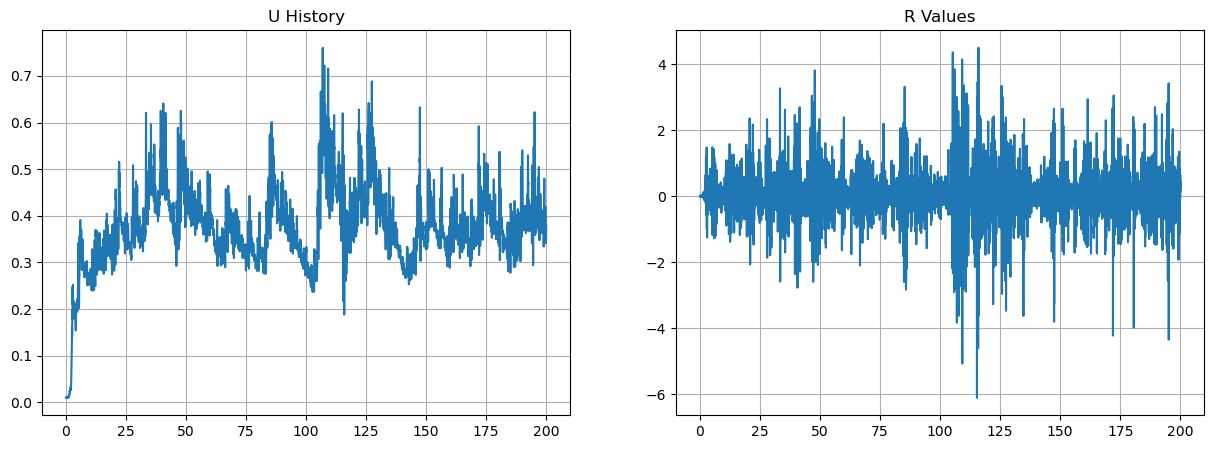

In [250]:
simulation.plot()

6.767912721528476e-05 -0.0031768939907621994 76.65029239766082
0.3811614294448642
[[ 4.55386654e-05 -3.48336230e-03  1.12573635e-06 -1.27201944e-02]
 [-3.48336230e-03  5.50188536e+01 -1.12444436e-03 -4.03992322e+00]
 [ 1.12573635e-06 -1.12444436e-03  3.85728101e-06 -5.83228965e-04]
 [-1.27201944e-02 -4.03992322e+00 -5.83228965e-04  1.49539150e+01]]


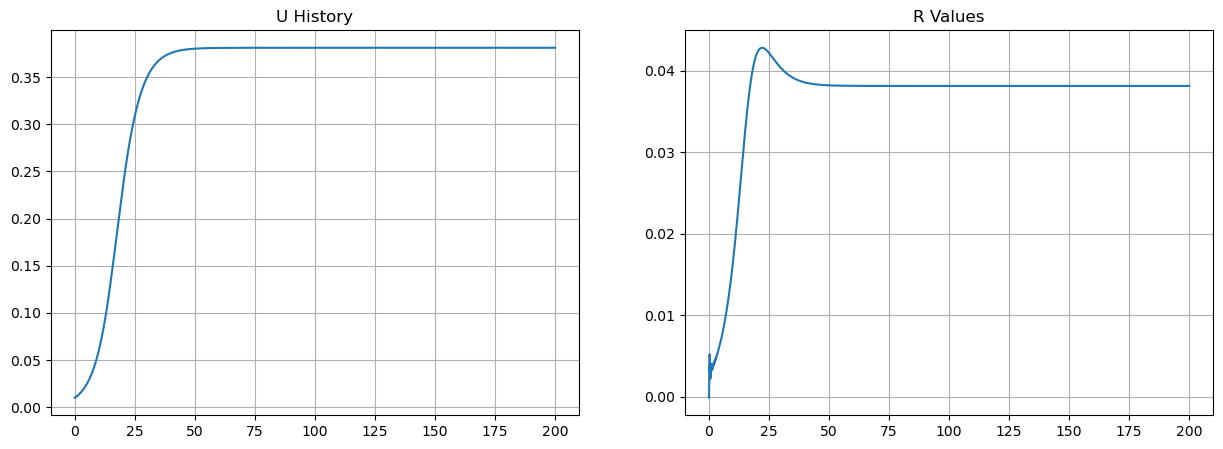

In [251]:

class SimulationSSD:
    def __init__(self, epsilon, N_0_squared, r_m, k, m, m_u, dt, total_time):

        #Make sure this is updated

        self.epsilon = epsilon
        self.N_0_squared = N_0_squared
        self.r_m = r_m
        self.k = k
        self.m = m
        self.m_u = m_u
        self.dt = dt
        self.total_time = total_time
        self.num_steps = int(total_time / dt)
        self.k_e_square = k**2 + m**2
        self.k_plus_square = k**2 + (m + m_u)**2

        self.W_e = np.array([[-1, (k / self.k_e_square)], [-k * N_0_squared, -1]])
        self.W_plus = np.array([[-1, -k / self.k_plus_square], [k * N_0_squared, -1]])
        self.L_e_plus = np.array([[(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), 0],
                                  [0, k / 2]])
        self.L_plus_e = np.array([[(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), 0],
                                  [0, -k / 2]]) 
        self.U = 0.01
        self.C = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
#         self.C = np.array([[0.0001490152423865438,
# -0.056342960706027546,
# 4.705459608940639e-06,
# -0.023997387342599555],
# [-0.056342960706027546,
# 153.61445123375822,
# -0.043334023121050586,
# -12.060326483759946],
# [4.705459608940639e-06,
# -0.043334023121050586,
# 4.7701541745783226e-05,
# -0.01911624053635777],
# [-0.023997387342599555,
# -12.060326483759946,
# -0.01911624053635777,
# 56.7986445738767]])


        self.A_U = np.array([[-1, (k / self.k_e_square), self.U*(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), self.U*0],
                             
                             [-k * N_0_squared, -1, self.U*0, self.U*self.k/2],

                             [self.U*(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), self.U*0, -1, -self.k/self.k_plus_square],

                             [self.U*0, self.U* -k / 2,k * N_0_squared, -1]])  
    
        self.Q = np.array([[8/self.k_e_square, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
        self.R = 0
        self.C_History = np.zeros((self.num_steps, 4, 4))              
        # self.C_History = np.zeros(self.num_steps)
        self.U_History = np.zeros(self.num_steps)
        self.R_History = np.zeros(self.num_steps)
        self.C = self.C.astype(np.float64)

    def simulate(self):
        for i in range(self.num_steps):

            self.A_U = np.array([[-1, (k / self.k_e_square), self.U*(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), self.U*0],
                             
                             [-k * N_0_squared, -1, self.U*0, self.U*self.k/2],

                             [self.U*(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), self.U*0, -1, -self.k/self.k_plus_square],

                             [self.U*0, self.U* -k / 2,k * N_0_squared, -1]]) 
                             
 
            C_dot = (self.A_U @ self.C + self.C @ np.transpose(self.A_U) + self.epsilon * self.Q) 
            U_dot = (self.R - self.r_m * self.U)

            
            self.C += C_dot * self.dt
            self.U += U_dot * self.dt
            self.R = 0.25 * self.k * (self.k_plus_square - self.k_e_square) * self.C[0][2]

            self.C_History[i] = self.C
            self.U_History[i] = self.U
            self.R_History[i] = self.R

    def make_plots(self):

        time_array = np.arange(0, self.total_time, .001)
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))

       
        axs[0].plot(time_array, self.U_History)
        axs[0].set_title(f"U History")
        axs[0].grid()
        axs[1].plot(time_array, self.R_History)
        axs[1].set_title(f"R Values")
        axs[1].grid()


        plt.show()


if __name__ == "__main__":
    # epsilon = 0.12394270273516043
    # N_0_squared = 318.8640217310387
    epsilon = .06
    N_0_squared = 640

    # epsilon = .02
    # N_0_squared = 200
    r_m = 0.1
    k = 2 * np.pi * 6
    m = 2 * np.pi * 3
    m_u = 2 * np.pi * 7
    dt = 0.001
    total_time = 200

    k_e_square = k**2 + m**2

    C_11 = (2*epsilon/k_e_square)*(2-(np.square(k) * N_0_squared/(k_e_square + np.square(k)*N_0_squared)))
    C_12 = -(2*epsilon*k*N_0_squared)/(k_e_square + np.square(k)*N_0_squared)
    C_22 = (2*epsilon*np.square(k)*np.square(N_0_squared))/(k_e_square + np.square(k)*N_0_squared)


    sim = SimulationSSD(epsilon, N_0_squared, r_m, k, m, m_u, dt, total_time)
    sim.simulate() 
    print(C_11, C_12, C_22)
    print(sim.U_History[-1])
    print(sim.C_History[-1])
    sim.make_plots()

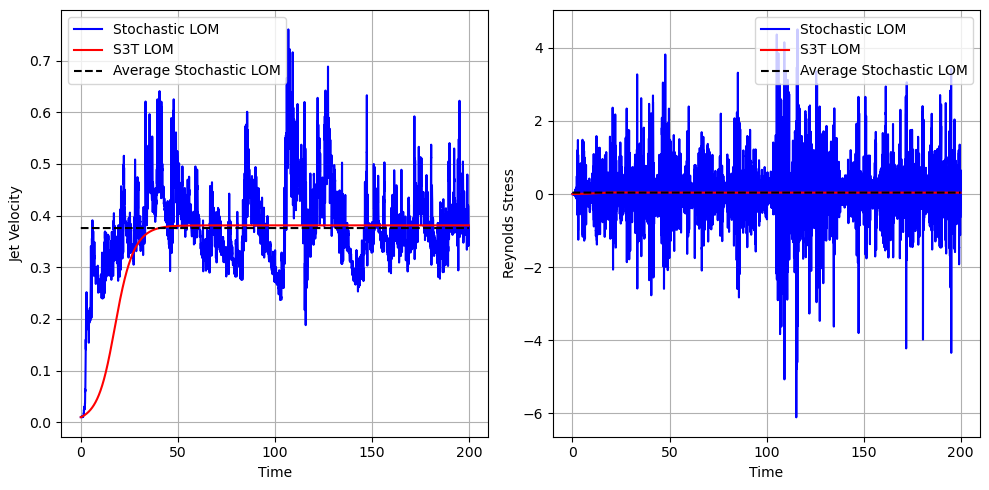

In [252]:
time_array = list(np.arange(0, 200, .001))
fig, axs = plt.subplots(1, 2, figsize = (10, 5))


axs[0].plot(time_array, simulation.U_history, color = 'Blue', label = 'Stochastic LOM')
axs[0].plot(time_array, sim.U_History, color = 'Red', label = 'S3T LOM')
axs[0].plot(time_array, np.full(len(time_array), np.mean(simulation.U_history)), color = 'Black', label = 'Average Stochastic LOM', linestyle = '--')
# axs[0].set_title(f"Jet Velocity")
# axs[0].set_ylim(0, .29)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Jet Velocity')
axs[0].grid()
axs[0].legend()


axs[1].plot(time_array, simulation.R_vals, color = 'Blue', label = 'Stochastic LOM')
axs[1].plot(time_array, sim.R_History, color = 'Red', label = 'S3T LOM')
axs[1].plot(time_array, np.full(len(time_array), np.mean(simulation.R_vals)), color = 'Black', label = 'Average Stochastic LOM', linestyle = '--')
# axs[1].set_ylim(-.5, .61)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Reynolds Stress')
axs[1].grid()
axs[1].legend(loc='upper right')

# axs[1].set_title(f"R Values")

axs[0].set_xticks([0, 50, 100, 150, 200])
axs[1].set_xticks([0, 50, 100, 150, 200])

plt.tight_layout()
plt.show()

In [253]:
# class SimulationSSD:
#     def __init__(self, epsilon, N_0_squared, r_m, k, m, m_u, dt, total_time):

#         #Make sure this is updated

#         self.epsilon = epsilon
#         self.N_0_squared = N_0_squared
#         self.r_m = r_m
#         self.k = k
#         self.m = m
#         self.m_u = m_u
#         self.dt = dt
#         self.total_time = total_time
#         self.num_steps = int(total_time / dt)
#         self.k_e_square = k**2 + m**2
#         self.k_plus_square = k**2 + (m + m_u)**2

#         self.W_e = np.array([[-1, (k / self.k_e_square)], [-k * N_0_squared, -1]])
#         self.W_plus = np.array([[-1, -k / self.k_plus_square], [k * N_0_squared, -1]])
#         self.L_e_plus = np.array([[(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), 0],
#                                   [0, k / 2]])
#         self.L_plus_e = np.array([[(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), 0],
#                                   [0, -k / 2]]) 
#         self.U = 0.01
#         self.C = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])

#         self.A_U = np.array([[-1, (k / self.k_e_square), self.U*(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), self.U*0],
                             
#                              [-k * N_0_squared, -1, self.U*0, self.U*self.k/2],

#                              [self.U*(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), self.U*0, -1, -self.k/self.k_plus_square],

#                              [self.U*0, self.U* -k / 2,k * N_0_squared, -1]])  
    
#         self.Q = np.array([[8/self.k_e_square, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
#         self.R = 0
#         self.C_History = np.zeros((self.num_steps, 4, 4))              
#         # self.C_History = np.zeros(self.num_steps)
#         self.U_History = np.zeros(self.num_steps)
#         self.R_History = np.zeros(self.num_steps)
#         self.C = self.C.astype(np.float64)

#     def simulate(self):
#         for i in range(self.num_steps):

#             self.A_U = np.array([[-1, (k / self.k_e_square), self.U*(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), self.U*0],
                             
#                              [-k * N_0_squared, -1, self.U*0, self.U*self.k/2],

#                              [self.U*(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), self.U*0, -1, -self.k/self.k_plus_square],

#                              [self.U*0, self.U* -k / 2,k * N_0_squared, -1]]) 
                             
 
#             C_dot = (self.A_U @ self.C + self.C @ np.transpose(self.A_U) + self.epsilon * self.Q) 
#             U_dot = (self.R - self.r_m * self.U)

            
#             self.C += C_dot * self.dt
#             self.U += U_dot * self.dt
#             self.R = 0.25 * self.k * (self.k_plus_square - self.k_e_square) * self.C[0][2]

#             self.C_History[i] = self.C
#             self.U_History[i] = self.U
#             self.R_History[i] = self.R

#     def make_plots(self):

#         time_array = np.arange(0, self.total_time, .001)
#         fig, axs = plt.subplots(1, 2, figsize = (15, 5))

       
#         axs[0].plot(time_array, self.U_History)
#         axs[0].set_title(f"U History")
#         axs[0].grid()
#         axs[1].plot(time_array, self.R_History)
#         axs[1].set_title(f"R Values")
#         axs[1].grid()


#         plt.show()


# if __name__ == "__main__":
#     epsilon_values = np.linspace(0.06, 0.24, 10)
#     N_0_squared_values = np.linspace(150, 640, 10)
#     combo_list = list(itertools.product(epsilon_values, N_0_squared_values))

#     r_m = 0.1
#     k = 2 * np.pi * 6
#     m = 2 * np.pi * 3
#     m_u = 2 * np.pi * 7
#     dt = 0.001
#     total_time = 200

#     k_e_square = k**2 + m**2
#     simulations = []
#     for idx, (epsilon, N_0_squared) in enumerate(combo_list):
#         sim = SimulationSSD(epsilon, N_0_squared, r_m, k, m, m_u, dt, total_time)
#         sim.simulate()
#         simulations.append(sim)
#         globals()[f'sim{idx}'] = sim

#     for idx, sim in enumerate(simulations):
#         globals()[f'sim{idx}Ustar'] = sim.U_History[-1]
#         globals()[f'sim{idx}Cstar'] = sim.C_History[-1]